# Zoom Backlighting Experiment Notebook

## Questions/Notes

Questions:
<ul>
    <li> Should do some sort of spatiotemporal processing maybe?? (See motion 2 compact slides)
        - Might find weird dropped frames, like zoom, up to me to decide if that is an issue or not. this might be a way to make it more stable, Can also use to improve detection. , but notice it is dropping 1 in 5 detections. so could say if detection is different enough, then reject the detection. 
        - could have temporal rules, if the pure photos doesn't work as well by itself.
    <li> Trouble with measuring backlit ness (see metrics in new resources)
    <li> When to do the processing? Only when we detect that our image is backlit? 
        - could try to come up with a test for this, could run haar cascade, if detect face then look look at average brightness in face bounding box, and see what average brightness elsewhere is. 
        - or if haar find a face, then know it is okay. If not, then find my stuff. 
        - Or could assume that you have a thing where it is a user option. And have the user figure it out 
    <li> Haar gives a square, do we want whole outline of person?
    <li> Haar doesn’t work with rotated heads (should prob just find another method for this)
</ul>

Issues:
- How can we measure how good it is compared to Zoom if we don't have a good way to route normal photos through the Zoom algorithm? Maybe "train" the algo on other dataset, and then use my own data for the metrics.

Notes from meeting November 16
- Haar cascade alternative??
    - Try lighteing up whole image (do straight up brightness operator), might have background be oversaturated. 
    - might also need to stack filters. eg. gain and then sharpness, or squaring of pixel values, (more separation), but the more you do stuff, the more you potentailly create weird artifacts. 
    - spend some time playing around with this. 
    - if haar is over grayscale, amkes it easier to implement, when you saturate over specfici color channels, you start to get wried things, need to make sure you don't overspill, python might have issues if over 255.
    - max or min function to cut off values if this is the case. 
    - a lot of the early filters we talked about could be useful. 
    - Set of filters taht may be helpful, Prof. wloka will send. 
    - Goal for this is to map face area to color range that haar can recognize. 
    - other option is to train haar cascade over low light images. 
- Could do this or could focus on getting face detection up and running. 
- If this ends up working to make the face look good, could also keep this over the segmentation that I find and then put in the old background. 
- High dynamic range photography TODO look this up. 
    - take photos at a bunch of differen tlighting, then combine together into one image. 
    - HDR algorithm. 
- Might not be an issue that we just have the bounding box. We could just segment the person. 
    - Mask RCNN for a person? Maybe ???
- IF we want to go with a learned method, that's okay as well. 

Notes from 11/27
- Could use a facial detection model from one of the papers and a deep learning model from one of the papers (or just non deep learning methods)
- OR: 
- Use keypoints?
    - Take some snapshots of the person. 
    - Figure out where face is in video, if backlighted then try to use other snapshots to fill in missing data
    - Look up paired techniques, see if applicable 
    - Maybe see if other face specific algos to do this

- GAN? Take good image and bad image. Want to process bad one so it is welllit (looks like a welllit image) BUT retains the facial landmark positions 
     - And make it look like same person as the other well lit photo
 
 Resources for papers with code: https://paperswithcode.com/search?q_meta=&q_type=&q=low+light
 Zero DCE, enlighten GAN seem most promising .Zero DCE: https://li-chongyi.github.io/Proj_Zero-DCE.html
 
 
 Could use https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html grab cut to get shoulders as well after we extract the faces from the photo.
 
 
 NEW PLAN
 - Go with old thing of extracting foreground (use the above thing (or mask RCNN) plus a thing that will recognize faces), + using tradiational methods
 - Compare this with just using one of the newest deep learning methods (eg. EnlightenGAN) (comparing site: http://mc.nankai.edu.cn/ll/)
 - Compare with results on Zoom
 - IF TIME: figure out how to apply this to videos
 
 
 TODOS:
 - collect dataset of photos of me in different lighting settings with Zoom auto and max manual lighting plus normal. 
     - Figure out how to quantify amt of lighting in order to do this. 
     - OR use dataset w/ different levels of lighting. But if we do this, need to figure out how to test the zoom algo on it. 
     
- get foreground extraction working
- get a deep learning model working

## Resources

### Used
- [The Haar Cascade tutorial](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/). Also includes some info about non-haar cascade face detection models.

### Might Use
- Yale Dataset with differing levels of backlit people's faces: [website](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html). Has illumination conditions labeled, etc.
- Some resources for doing low light image enhancement: [Github](https://github.com/dawnlh/awesome-low-light-image-enhancement)
    - Other ways to do facial detection
        - [Recurrent Exposure Generation for Low-Light Face Detection
](https://arxiv.org/abs/2007.10963)
        - [HLA Face]( https://daooshee.github.io/HLA-Face-Website/)
        - [Single-Stage_Face_Detection_Under_Extremely_Low-Light_Conditions](https://openaccess.thecvf.com/content/ICCV2021W/RLQ/papers/Yu_Single-Stage_Face_Detection_Under_Extremely_Low-Light_Conditions_ICCVW_2021_paper.pdf)
    - Benchmark? [WIDER FACE benchmark](http://shuoyang1213.me/WIDERFACE/)
- Google stuff about doing directional light enhancement on photos. [Blog post](https://ai.googleblog.com/2020/12/portrait-light-enhancing-portrait.html) and [facial detection keypoint model documentation](https://google.github.io/mediapipe/solutions/face_mesh.html)
</ul>
- Some discussion about how to do automatic lighting correction in open cv [Stack Overflow](https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape)

## Setup

First make necessary imports. Make sure we run the jupyter notebook instance using the (base) environment, else some of these packages won't be installed yet. 

In [2]:
import numpy as np
from PIL import Image
import pylab
from glob import glob
import cv2
from icecream import ic
import os
import unittest

%matplotlib inline
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (12, 10)

Here's our images! We load them into a dictionary for future reference.

In [3]:
imgFolder = "images"
imgDict = {}
for filename in os.listdir(imgFolder):
    if filename != ".DS_Store":
        imgDict[filename] = np.array(Image.open(imgFolder + '/' + filename))
[key for key in imgDict.keys()] # print out the keys for future reference

['badBrightnessPhotoCropped.jpg',
 'badBrightnessPhoto.png',
 'yaleB17_P00A-110E+65 copy.pgm',
 'well-lit1.jpg',
 'noAdjustLowLight.png',
 'manualAdjustLowLightMax.png',
 'well-lit-with-mask.jpg',
 'yaleB17_P02A+000E+90 copy.pgm',
 'adjustForLowLightManualHalfway.png',
 'yaleB17_P02_Ambient copy.pgm',
 'yaleB17_P00A+130E+20 copy.pgm',
 'yaleB17_P04A+000E+90 copy.pgm',
 'autoAdjustForLowLight.png',
 'yaleB17_P00A+000E+90 copy.pgm']

Here's the first image we are looking at, which is just a typical backlit image

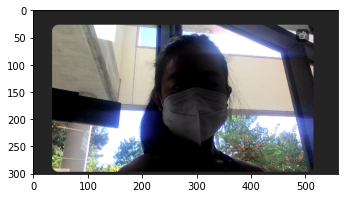

In [4]:
plt.subplot(2,2,1)
plt.imshow(imgDict['badBrightnessPhoto.png'])

Here's the other four images, all of which have differing levels of backlit adjustment from Zoom's own algorithms.

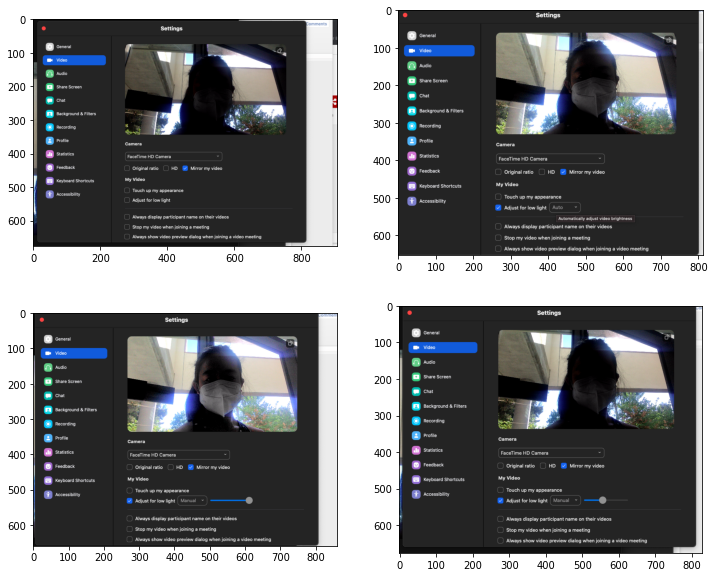

In [5]:

plt.subplot(2,2,1)
plt.imshow(imgDict["noAdjustLowLight.png"])

plt.subplot(2,2,2)
plt.imshow(imgDict['autoAdjustForLowLight.png'])

plt.subplot(2,2,3)
plt.imshow(imgDict['manualAdjustLowLightMax.png'])

plt.subplot(2,2,4)
plt.imshow(imgDict['adjustForLowLightManualHalfway.png'])

## Face detection (Haar)

FaceDetect holds methods to detect the face from a picture or video stream. I wrote this class by adapting it from some previous work I did with Haar cascades (scroll to the bottom of [this file](https://github.com/tennisoctocat/push-up-poker/blob/main/training/FacialFeatures.ipynb), which I had previously adapted from this [tutorial](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/).


In [6]:
"""FaceDetect holds methods to detect the face from a picture or video stream."""

class FaceDetect():
	def __init__(self):
		self.faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
		self.faces = [] # faces in form of x, y, width, height
		self.shapeOfLastDetectedImg = (0, 0)

	# Public method, lets you use whatever implmentation you want. 
	def getNewFrame(self, img, timeStep=0):
		"""Gets the new frame to show on the screen. Called by external classes, etc."""
		# Always run detection of img's shape changed. Otherwise we might get
		# an index out of bounds exception for when the old faces run off the edges 
			# of the new frame.
        # Timestep included for video processing (only do processing every 20 timesteps)
		if timeStep % 20 == 0 or np.array(img).shape != self.shapeOfLastDetectedImg:
			self._get_faces_with_haar(img)
			return self._draw_faces(img)
		return self._draw_faces(img)

	def _draw_faces(self, img):
		"""Draws a white box for every face in the self.faces array"""
        
		if self.faces is None:
			return img
        
		numChannels = img.shape[-1] if len(img.shape) == 3 else 1
		for face in self.faces:
			x,y,w,h = face
			ic(numChannels)
			img[y: y + h, x] = [255] * numChannels # Left off here, need to draw the actual bounding boxes. 
			img[y: y + h, x + w] = [255] * numChannels# Left off here, need to draw the actual bounding boxes. 
			img[y, x:x + w] = [255] * numChannels
			img[y + h, x:x + w] = [255] * numChannels
		return img

	def _get_faces_with_haar(self, img):
		"""Uses haar cascades to detect faces and save them in the self.faces array"""
		if img is None:
			return 

		img = np.array(img)

		# Detect faces
		self.faces = self.faceCascade.detectMultiScale(img, minNeighbors=3, minSize=(int(img.shape[0]/5), int(img.shape[0]/5)))
		self.shapeOfLastDetectedImg = img.shape

		# Print so we know what is happening
		if len(self.faces) > 1:
			print("faces greater than 1 ")
		elif len(self.faces) == 0:
			print("no face found ")




Create a `FaceDetect` instance in order to detect and display images with bounding boxes for the faces.

In [7]:
faceDetect = FaceDetect()

We note that Haar cascades doesn't do so well when I'm wearing a mask and it is dark.

no face found 


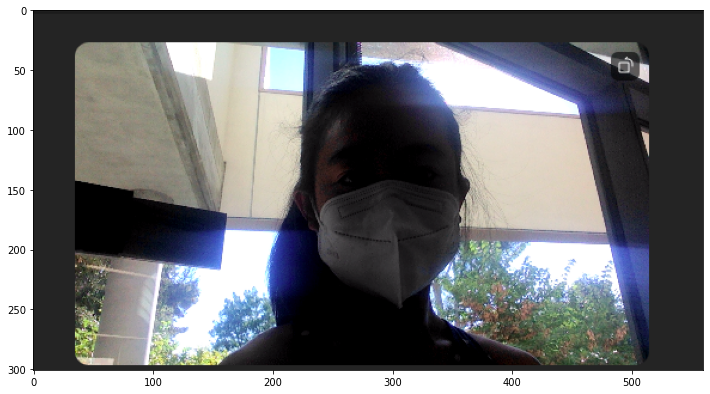

In [8]:
badBrightnessFacesImg = faceDetect.getNewFrame(imgDict['badBrightnessPhoto.png'])
plt.imshow(badBrightnessFacesImg)

But, it works just fine on normal photos.

ic| numChannels: 3


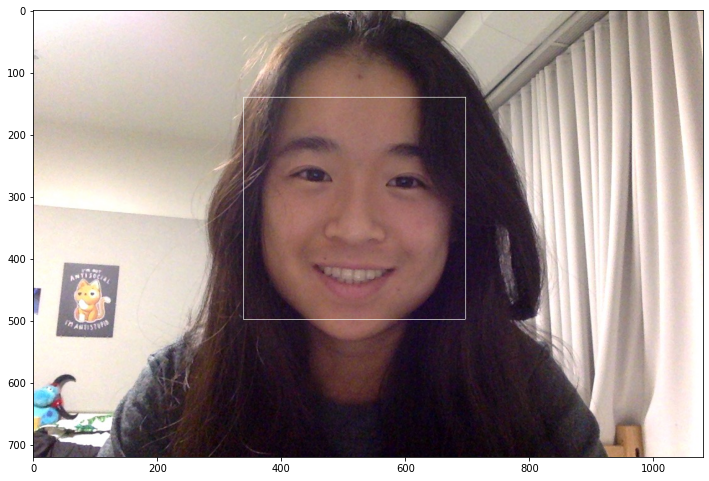

In [9]:
normalFacesImg = faceDetect.getNewFrame(imgDict['well-lit1.jpg'])
plt.imshow(normalFacesImg)

# Trying to mess with photo before using Haar cascades

Let's try brightening the image before using Haar cascades.

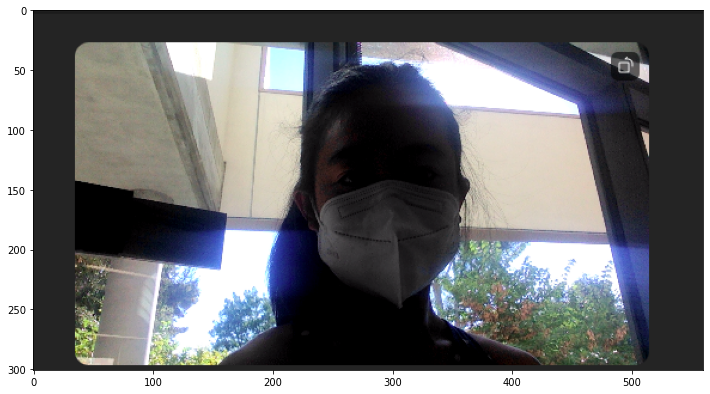

In [10]:
origImg = imgDict['badBrightnessPhoto.png']
plt.imshow(origImg)

In [11]:
origImg

array([[[ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        ...,
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255]],

       [[ 30,  30,  30, 255],
        [ 30,  30,  30, 255],
        [ 30,  30,  30, 255],
        ...,
        [ 30,  30,  30, 255],
        [ 30,  30,  30, 255],
        [ 30,  30,  30, 255]],

       [[ 26,  26,  26, 255],
        [ 26,  26,  26, 255],
        [ 26,  26,  26, 255],
        ...,
        [ 26,  26,  26, 255],
        [ 26,  26,  26, 255],
        [ 26,  26,  26, 255]],

       ...,

       [[ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        ...,
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255]],

       [[ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        ...,
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255],
        [ 36,  36,  36, 255]],

       [[ 36

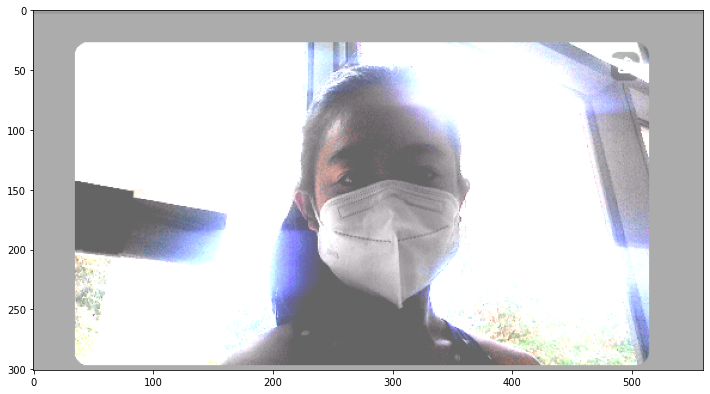

In [36]:
new_image = cv2.convertScaleAbs(origImg, alpha=2, beta=100)
plt.imshow(new_image)

no face found 


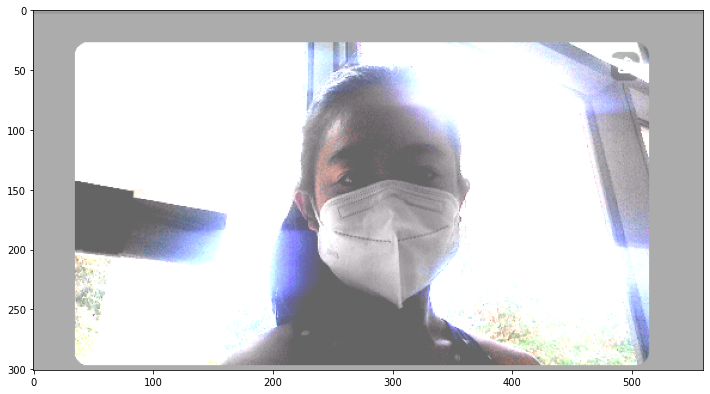

In [37]:
detectImg = faceDetect.getNewFrame(new_image)
plt.imshow(detectImg)

However, we note that if we use this technique on another face that is not wearing a mask, that it indeed does work. So maybe the issue is the mask wearing, as opposed to the lack of light. 

no face found 


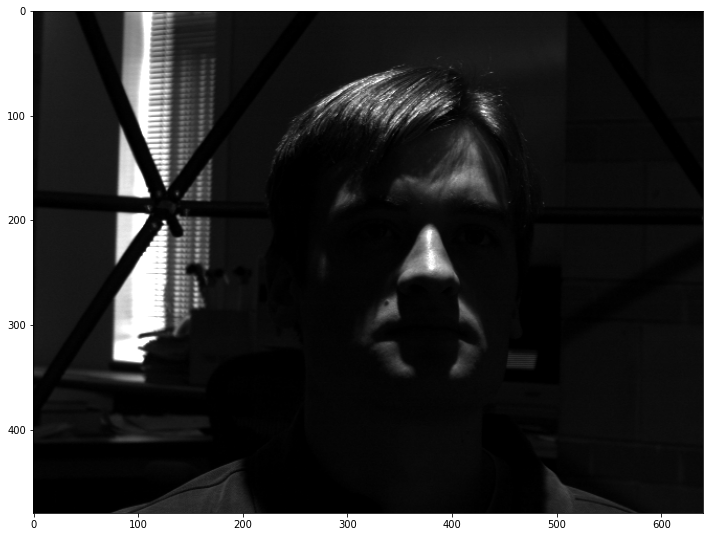

In [29]:
yale1Img = faceDetect.getNewFrame(imgDict['yaleB17_P02A+000E+90 copy.pgm'])
plt.imshow(yale1Img, cmap="gray")

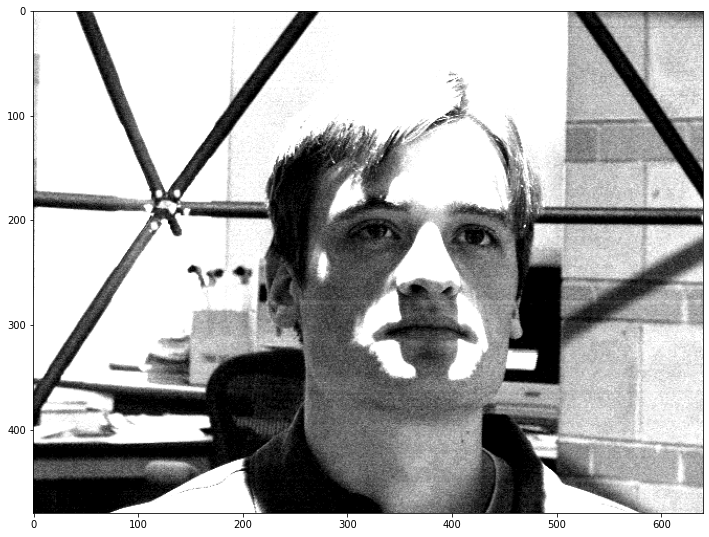

In [32]:
yale1ImgChanged = cv2.convertScaleAbs(yale1Img, alpha=4, beta=200)
plt.imshow(yale1ImgChanged, cmap = "gray")

ic| numChannels: 1


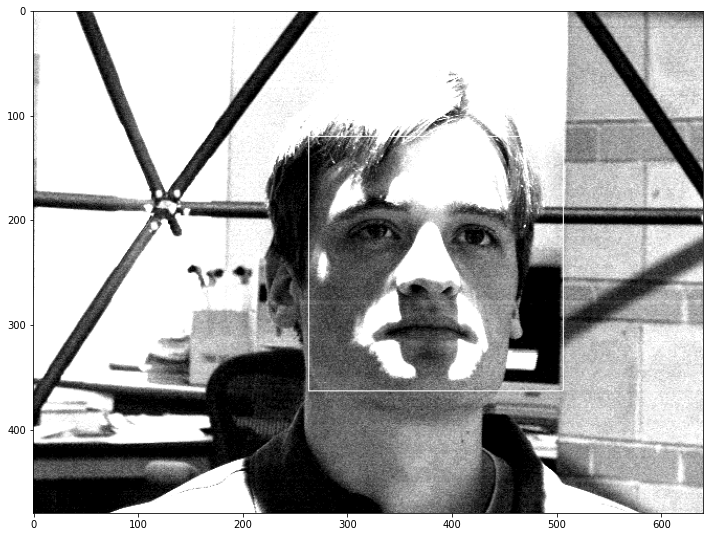

In [33]:
detectImg = faceDetect.getNewFrame(yale1ImgChanged)
plt.imshow(detectImg, cmap="gray")

In [114]:
yale1ImgChanged.shape

(480, 640)

However, it does work when put on a well-lit photo of someone wearing a mask. So perhaps this is not the problem.

ic| numChannels: 3
ic| numChannels: 3


faces greater than 1 


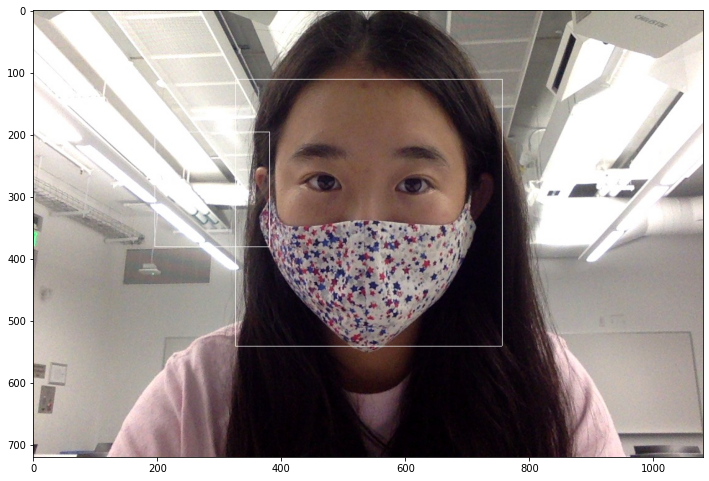

In [116]:
well_lit_detected_img = faceDetect.getNewFrame(imgDict['well-lit-with-mask.jpg'])
plt.imshow(well_lit_detected_img, cmap="gray")

QUESTION: What do I do once I figure out what a good set of parameters would be for a particular image? Because whether or not something works out depends on the image??? How do we typcially do this? eg. for green screen hw, etc.

## Alternate face detection models